In [1]:
import sys, os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
print(torch.__version__)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

1.7.0+cu101


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!



/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


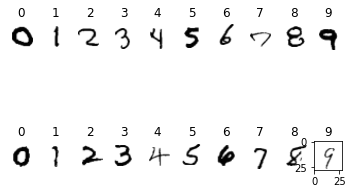

In [2]:
train_mnist=datasets.MNIST('data', train=True, download=True)
y_train_orig=train_mnist.targets.numpy()
for i in range(10):
  num_digits=2
  indices=np.random.choice(np.where(y_train_orig==i)[0],num_digits)
  for j in range(num_digits):
    plt.axis('off')
    plt.subplot(num_digits,10,10*j+i+1).set_title('{}'.format(i))
    img,_=train_mnist[indices[j]]
    plt.imshow(img, cmap='Greys')
plt.show()

In [3]:
batch_size = 128
use_cuda = torch.cuda.is_available()
print(use_cuda)

torch.manual_seed(1)

normalize = transforms.Normalize((0.1307,), (0.3081,))  # MNIST

train_transform=transforms.Compose([
                        transforms.ToTensor(),
                        normalize
                    ])
train_dataset = datasets.MNIST(root='data', train=True, 
                download=True, transform=train_transform)


test_transform=transforms.Compose([
                        transforms.ToTensor(),
                        normalize
                    ])
test_dataset = datasets.MNIST(root='data', train=False, 
            download=True, transform=test_transform)

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(0.1 * num_train))
num_train = len(train_dataset)
split = int(np.floor(0.1 * num_train))
train_set, val_set = torch.utils.data.random_split(train_dataset, [num_train-split, split])
print(len(train_set), len(val_set))

train_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size, shuffle=True, **kwargs)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=batch_size, shuffle=False, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size, shuffle=False, **kwargs)

True
54000 6000


In [4]:
input_size=train_dataset[0][0].shape
num_classes=len(train_dataset.classes)


class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.fc = nn.Linear(np.prod(input_size), num_classes)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc(x)
        output = F.log_softmax(x, dim=1)
        return output


class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(np.prod(input_size), 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output


class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.fc1 = nn.Linear(np.prod(input_size), 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 80)
        self.fc4 = nn.Linear(80, num_classes)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        output = F.log_softmax(x, dim=1)
        return output


class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        self.fc1 = nn.Linear(np.prod(input_size), 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

class Net5(nn.Module):
    def __init__(self):
        super(Net5, self).__init__()
        self.fc1 = nn.Linear(np.prod(input_size), 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 80)
        self.fc4 = nn.Linear(80, num_classes)
        self.bn1 = nn.BatchNorm1d(200)
        self.bn2 = nn.BatchNorm1d(100)
        self.bn3 = nn.BatchNorm1d(80)
        self.drop_layer1 = nn.Dropout(p=0.1)
        self.drop_layer2 = nn.Dropout(p=0.05)

    def forward(self, x):
        x = self.drop_layer1(torch.flatten(x, 1))
        x = F.relu(self.bn1(self.drop_layer1(self.fc1(x))))
        x = F.leaky_relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.rrelu(self.fc4(x))
        output = F.log_softmax(x, dim=1)
        return output


def train(model, device, train_loader, optimizer, epoch):
  train_loss = 0.0
  total_train = 0
  correct_train = 0
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = F.nll_loss(output, target)
      loss.backward()
      optimizer.step()
      if batch_idx % 10 == 0:
        display('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()), display_id=str(epoch), update=True)
      
      # accuracy
      _, predicted = torch.max(output.data, 1)
      train_loss += loss.item()
      total_train += target.nelement()  # number of pixel in the batch
      correct_train += predicted.eq(target.data).sum().item() # sum all precited pixel values
  
  epoch_loss = train_loss / len(train_loader.dataset)
  epoch_acc = 100.*(correct_train / total_train)
  print('Train set: Average loss: {:.4f}, Accuracy: {}/{} {:.0f}%\n'.format(
      epoch_loss,correct_train, total_train, epoch_acc))
  return epoch_loss,epoch_acc

def test(model, device, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  accuracy=100. * correct / len(test_loader.dataset)

  print('Val set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      accuracy))
  return test_loss,accuracy

In [5]:
device = torch.device("cuda" if use_cuda else "cpu")

### 1st try

In [ ]:
epochs = 4
model = Net1().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = StepLR(optimizer, step_size=2, gamma=0.7)
train_accuracies,val_accuracies=[],[]
for epoch in range(1, epochs + 1):
    train_loss,train_accuracy=train(model, device, train_loader, optimizer, epoch)
    train_accuracies.append(train_accuracy)
    val_loss,val_accuracy=test(model, device, val_loader)
    val_accuracies.append(val_accuracy)
    scheduler.step()

'Train Epoch: 1 [53760/54000 (100%)] Loss: 0.152999'

Train set: Average loss: 0.0030, Accuracy: 47978/54000 89%

Val set: Average loss: 0.3133, Accuracy: 5463/6000 (91%)



'Train Epoch: 2 [53760/54000 (100%)] Loss: 0.244559'

Train set: Average loss: 0.0024, Accuracy: 49295/54000 91%

Val set: Average loss: 0.2946, Accuracy: 5504/6000 (92%)



'Train Epoch: 3 [53760/54000 (100%)] Loss: 0.246236'

Train set: Average loss: 0.0022, Accuracy: 49626/54000 92%

Val set: Average loss: 0.2847, Accuracy: 5523/6000 (92%)



'Train Epoch: 4 [53760/54000 (100%)] Loss: 0.288943'

Train set: Average loss: 0.0022, Accuracy: 49730/54000 92%

Val set: Average loss: 0.2791, Accuracy: 5513/6000 (92%)



4 4


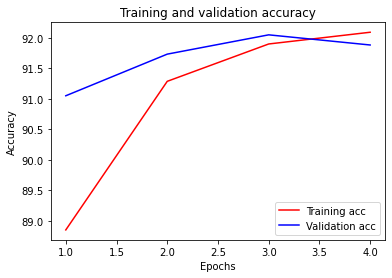

In [ ]:
print(len(train_accuracies),len(val_accuracies))
epochs = range(1, len(train_accuracies) + 1)

plt.plot(epochs, train_accuracies, 'r', label='Training acc')
plt.plot(epochs, val_accuracies, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
score = test(model, device, test_loader)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Val set: Average loss: 0.2773, Accuracy: 9220/10000 (92%)

Test loss: 0.27734257791042327
Test accuracy: 92.2


### 2nd try

In [ ]:
epochs = 4
model = Net2().to(device)
optimizer = optim.ASGD(model.parameters(), lr=0.3)
scheduler = StepLR(optimizer, step_size=2, gamma=0.7)
train_accuracies,val_accuracies=[],[]
for epoch in range(1, epochs + 1):
    train_loss,train_accuracy=train(model, device, train_loader, optimizer, epoch)
    train_accuracies.append(train_accuracy)
    val_loss,val_accuracy=test(model, device, val_loader)
    val_accuracies.append(val_accuracy)
    scheduler.step()

'Train Epoch: 1 [53760/54000 (100%)] Loss: 0.096826'

Train set: Average loss: 0.0032, Accuracy: 47189/54000 87%

Val set: Average loss: 0.1323, Accuracy: 5758/6000 (96%)



'Train Epoch: 2 [53760/54000 (100%)] Loss: 0.168073'

Train set: Average loss: 0.0009, Accuracy: 52137/54000 97%

Val set: Average loss: 0.1082, Accuracy: 5794/6000 (97%)



'Train Epoch: 3 [53760/54000 (100%)] Loss: 0.126681'

Train set: Average loss: 0.0005, Accuracy: 52888/54000 98%

Val set: Average loss: 0.0871, Accuracy: 5838/6000 (97%)



'Train Epoch: 4 [53760/54000 (100%)] Loss: 0.018573'

Train set: Average loss: 0.0004, Accuracy: 53157/54000 98%

Val set: Average loss: 0.0868, Accuracy: 5836/6000 (97%)



4 4


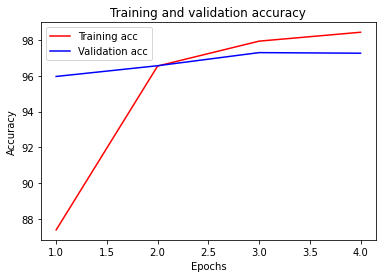

In [ ]:
print(len(train_accuracies),len(val_accuracies))
epochs = range(1, len(train_accuracies) + 1)

plt.plot(epochs, train_accuracies, 'r', label='Training acc')
plt.plot(epochs, val_accuracies, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
score = test(model, device, test_loader)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Val set: Average loss: 0.0814, Accuracy: 9757/10000 (98%)

Test loss: 0.08138975221128203
Test accuracy: 97.57


### 3rd try


In [ ]:
epochs = 4
model = Net3().to(device)
optimizer = optim.ASGD(model.parameters(), lr=0.4)
scheduler = StepLR(optimizer, step_size=1, gamma=0.3)
train_accuracies,val_accuracies=[],[]
for epoch in range(1, epochs + 1):
    train_loss,train_accuracy=train(model, device, train_loader, optimizer, epoch)
    train_accuracies.append(train_accuracy)
    val_loss,val_accuracy=test(model, device, val_loader)
    val_accuracies.append(val_accuracy)
    scheduler.step()

'Train Epoch: 1 [53760/54000 (100%)] Loss: 0.163951'

Train set: Average loss: 0.0033, Accuracy: 46754/54000 87%

Val set: Average loss: 0.1345, Accuracy: 5732/6000 (96%)



'Train Epoch: 2 [53760/54000 (100%)] Loss: 0.064200'

Train set: Average loss: 0.0007, Accuracy: 52574/54000 97%

Val set: Average loss: 0.0915, Accuracy: 5834/6000 (97%)



'Train Epoch: 3 [53760/54000 (100%)] Loss: 0.052292'

Train set: Average loss: 0.0005, Accuracy: 53074/54000 98%

Val set: Average loss: 0.0834, Accuracy: 5833/6000 (97%)



'Train Epoch: 4 [53760/54000 (100%)] Loss: 0.017746'

Train set: Average loss: 0.0004, Accuracy: 53213/54000 99%

Val set: Average loss: 0.0820, Accuracy: 5839/6000 (97%)



4 4


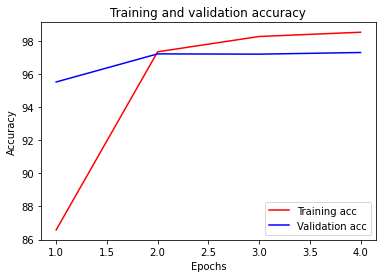

In [ ]:
print(len(train_accuracies),len(val_accuracies))
epochs = range(1, len(train_accuracies) + 1)

plt.plot(epochs, train_accuracies, 'r', label='Training acc')
plt.plot(epochs, val_accuracies, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
score = test(model, device, test_loader)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Val set: Average loss: 0.0786, Accuracy: 9751/10000 (98%)

Test loss: 0.07862658791281282
Test accuracy: 97.51


### 4th try

In [ ]:
epochs = 4
model = Net4().to(device)
optimizer = optim.ASGD(model.parameters(), lr=0.4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.6)
train_accuracies,val_accuracies=[],[]
for epoch in range(1, epochs + 1):
    train_loss,train_accuracy=train(model, device, train_loader, optimizer, epoch)
    train_accuracies.append(train_accuracy)
    val_loss,val_accuracy=test(model, device, val_loader)
    val_accuracies.append(val_accuracy)
    scheduler.step()

'Train Epoch: 1 [53760/54000 (100%)] Loss: 0.102043'

Train set: Average loss: 0.0016, Accuracy: 50673/54000 94%

Val set: Average loss: 0.1284, Accuracy: 5760/6000 (96%)



'Train Epoch: 2 [53760/54000 (100%)] Loss: 0.118699'

Train set: Average loss: 0.0007, Accuracy: 52543/54000 97%

Val set: Average loss: 0.0858, Accuracy: 5821/6000 (97%)



'Train Epoch: 3 [53760/54000 (100%)] Loss: 0.057412'

Train set: Average loss: 0.0004, Accuracy: 53145/54000 98%

Val set: Average loss: 0.0755, Accuracy: 5855/6000 (98%)



'Train Epoch: 4 [53760/54000 (100%)] Loss: 0.059349'

Train set: Average loss: 0.0003, Accuracy: 53383/54000 99%

Val set: Average loss: 0.0707, Accuracy: 5867/6000 (98%)



4 4


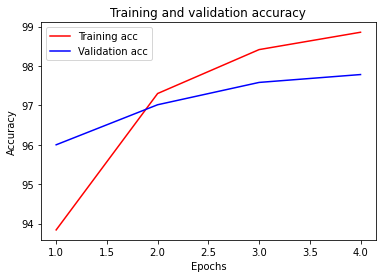

In [ ]:
print(len(train_accuracies),len(val_accuracies))
epochs = range(1, len(train_accuracies) + 1)

plt.plot(epochs, train_accuracies, 'r', label='Training acc')
plt.plot(epochs, val_accuracies, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Сильно переобучилась

In [ ]:
score = test(model, device, test_loader)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Val set: Average loss: 0.0697, Accuracy: 9787/10000 (98%)

Test loss: 0.0697490773100406
Test accuracy: 97.87


### 5th try

In [6]:
epochs = 6
model = Net5().to(device)
optimizer = optim.ASGD(model.parameters(), lr=0.5)
scheduler = StepLR(optimizer, step_size=1, gamma=0.6)
train_accuracies,val_accuracies=[],[]
for epoch in range(1, epochs + 1):
    train_loss,train_accuracy=train(model, device, train_loader, optimizer, epoch)
    train_accuracies.append(train_accuracy)
    val_loss,val_accuracy=test(model, device, val_loader)
    val_accuracies.append(val_accuracy)
    scheduler.step()

'Train Epoch: 1 [53760/54000 (100%)] Loss: 0.132655'

Train set: Average loss: 0.0018, Accuracy: 50158/54000 93%

Val set: Average loss: 0.1202, Accuracy: 5772/6000 (96%)



'Train Epoch: 2 [53760/54000 (100%)] Loss: 0.132608'

Train set: Average loss: 0.0008, Accuracy: 52314/54000 97%

Val set: Average loss: 0.0873, Accuracy: 5836/6000 (97%)



'Train Epoch: 3 [53760/54000 (100%)] Loss: 0.071223'

Train set: Average loss: 0.0006, Accuracy: 52779/54000 98%

Val set: Average loss: 0.0702, Accuracy: 5863/6000 (98%)



'Train Epoch: 4 [53760/54000 (100%)] Loss: 0.110090'

Train set: Average loss: 0.0004, Accuracy: 53059/54000 98%

Val set: Average loss: 0.0641, Accuracy: 5877/6000 (98%)



'Train Epoch: 5 [53760/54000 (100%)] Loss: 0.029020'

Train set: Average loss: 0.0004, Accuracy: 53205/54000 99%

Val set: Average loss: 0.0575, Accuracy: 5881/6000 (98%)



'Train Epoch: 6 [53760/54000 (100%)] Loss: 0.067354'

Train set: Average loss: 0.0003, Accuracy: 53266/54000 99%

Val set: Average loss: 0.0574, Accuracy: 5888/6000 (98%)



6 6


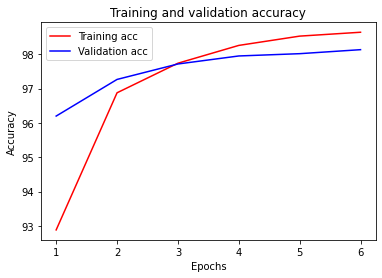

In [7]:
print(len(train_accuracies),len(val_accuracies))
epochs = range(1, len(train_accuracies) + 1)

plt.plot(epochs, train_accuracies, 'r', label='Training acc')
plt.plot(epochs, val_accuracies, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [8]:
score = test(model, device, test_loader)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Val set: Average loss: 0.0511, Accuracy: 9842/10000 (98%)

Test loss: 0.0511258036592044
Test accuracy: 98.42


### Best res tet:

In [9]:
model

Net5(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=80, bias=True)
  (fc4): Linear(in_features=80, out_features=10, bias=True)
  (bn1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop_layer1): Dropout(p=0.1, inplace=False)
  (drop_layer2): Dropout(p=0.05, inplace=False)
)